In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [3]:
sys.path.append('../src/')

from SSAP import SSAP
from mydatasets import preprocess
import mydatasets as datasets
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

def num_parameters(m):
    return sum([np.prod(v.shape) for v in m.parameters()])

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## load model and get dataset

In [4]:
name = '../exp/raftsup_0pretrain_0/'
# name = '../exp/fullsup_0pretrain/'
trained_model = name + 'trained_model'

os.listdir(trained_model)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['model_120000.pth',
 'model_90000.pth',
 'model_50000.pth',
 'model_110000.pth',
 'model_160000.pth',
 'model_100000.pth',
 'model_40000.pth',
 'model_10000.pth',
 'model_170000.pth',
 'model_140000.pth',
 'model_30000.pth',
 'model_150000.pth',
 'model_70000.pth',
 'model_60000.pth',
 'model_20000.pth',
 'model_130000.pth',
 'model_80000.pth']

In [19]:
mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

tdw_dataset = datasets.TdwAffinityDataset(training=False, mean=mean, std=std, 
                                          raft_ckpt=None, 
                                          single_supervision=False,
#                                           test_splits="4",
#                                           test_filepattern="0*[0-4]",
                                          full_supervision=True)

print(len(tdw_dataset))

500


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda', index=0)

In [7]:
ckpt_iter = 170000
load_path = os.path.join(trained_model, 'model_' + str(ckpt_iter) + '.pth')
use_pretrained = False

AFF_R = 5
model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R, pretrained_backbone=use_pretrained)
model = model.to(device)

did_load = model.load_state_dict(torch.load(load_path)) 
model.eval()
print(did_load)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>


### check eval on single example

In [8]:
ex = 3
img, cats, _ = [x[None].cuda() for x in tdw_dataset[ex]]
outputs = model(torch.cat([img]*3, 0))
ins, ins_list = make_ins_seg(outputs, st_for=0,
                            en_for=5, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dbear/tenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
outputs[1].shape

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([3, 2, 32, 32])

[  0  92  99 106]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


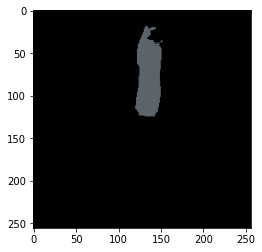

In [10]:
cls_ = 0
print(np.unique(ins[cls_]))
plt.imshow(ins[cls_])
plt.show()

In [11]:
import dorsalventral.models.segmentation.aggregate_pseudolabels as confidence
import dorsalventral.trainval.segmentation_metrics as metrics
from tqdm import tqdm

def segments_to_masks(segments, max_segments=16):
    masks = torch.from_numpy(segments).cuda().permute(2,0,1)
    masks = datasets.TdwAffinityDataset._object_id_hash(masks) # [1,H,W]
    unique = torch.unique(masks)[:max_segments]
    masks = (unique[:,None,None] == masks)
    return masks

def val_gt_moving_iou(model, dataset, ex=3, val_single=True):
    dataset.is_test = True
    if not isinstance(ex, list):
        ex = [ex]
    imgs, gts = [], []
    for e in ex:
        img, gt_full, gt_moving = dataset[e]
        imgs.append(img)
        gts.append(gt_moving if val_single else gt_full)
    imgs = torch.stack(imgs, 0).cuda()
    gts = torch.stack(gts, 0)    
    out = model(imgs)
    
    preds = []
    for i in range(len(ex)):
        _out = [v[i][None] for v in out]
        ins, _ = make_ins_seg(_out, st_for=0, en_for=5, min_size=5)
        pred = segments_to_masks(ins[0])
        pred = pred.long().argmax(0).to(torch.int32).cpu()
        preds.append(pred)

    preds = torch.stack(preds, 0)
    
    size = list(gts.shape[-2:])
    
    M = metrics.SegmentationMetrics(
        gt_objects=gts.to(torch.int32),
        pred_objects=preds,
        size=size
    )
    
    M.compute_matched_IoUs(exclude_gt_ids=[0])
    ious_per_obj = M.best_ious
    ious = M.mean_ious
    return (imgs, preds, gts, ious, ious_per_obj)

def val_objects(model, dataset, examples=range(4), print_every=10, val_single=True):
    if examples is None:
        examples = range(len(dataset))
    
    ious = []
    running_mean = 0.
    for i, ex in enumerate(tqdm(examples)):
        _, _, _, iou, _ = val_gt_moving_iou(model, dataset, ex=ex, val_single=val_single)
        ious.append(iou[0])
        if not np.isnan(iou[0]):
            running_mean += iou[0] / print_every
        if ((i + 1) % print_every) == 0:
            print("mean of last %d ---- %.3f" % (print_every, running_mean))
            print("mean of full %d ---- %.3f" % (i+1, np.nanmean(np.array(ious))))
            running_mean = 0.
        
    mean_iou = np.nanmean(np.array(ious))
    return mean_iou, ious

# pred, gt, ious, ious_per_obj = val_gt_moving_iou(model, tdw_dataset, ex=[2,3], val_single=False)
# print(ious)
mean_ious, ious = val_objects(model, tdw_dataset, examples=range(6), print_every=2, val_single=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
 33%|███▎      | 2/6 [00:01<00:01,  2.11it/s]

mean of last 2 ---- 0.040
mean of full 2 ---- 0.040


 83%|████████▎ | 5/6 [00:03<00:00,  1.72it/s]

mean of last 2 ---- 0.196
mean of full 4 ---- 0.118


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

mean of last 2 ---- 0.027
mean of full 6 ---- 0.088


In [12]:
# raft-trained 170k
mean_ious, ious = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=False)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/500 [00:04<01:57,  4.18it/s]

mean of last 10 ---- 0.071
mean of full 10 ---- 0.071


  4%|▍         | 21/500 [00:09<03:51,  2.07it/s]

mean of last 10 ---- 0.149
mean of full 20 ---- 0.110


  6%|▌         | 31/500 [00:17<04:26,  1.76it/s]

mean of last 10 ---- 0.095
mean of full 30 ---- 0.105


  8%|▊         | 40/500 [00:22<02:50,  2.70it/s]

mean of last 10 ---- 0.101
mean of full 40 ---- 0.104


 10%|█         | 51/500 [00:27<02:35,  2.89it/s]

mean of last 10 ---- 0.117
mean of full 50 ---- 0.107


 12%|█▏        | 60/500 [00:35<02:56,  2.49it/s]

mean of last 10 ---- 0.102
mean of full 60 ---- 0.106


 14%|█▍        | 71/500 [00:42<03:40,  1.95it/s]

mean of last 10 ---- 0.133
mean of full 70 ---- 0.110


 16%|█▌        | 81/500 [00:46<02:50,  2.45it/s]

mean of last 10 ---- 0.145
mean of full 80 ---- 0.114


 18%|█▊        | 90/500 [00:51<03:10,  2.16it/s]

mean of last 10 ---- 0.084
mean of full 90 ---- 0.111


 20%|██        | 100/500 [00:56<01:36,  4.13it/s]

mean of last 10 ---- 0.104
mean of full 100 ---- 0.110


 22%|██▏       | 111/500 [01:03<02:20,  2.78it/s]

mean of last 10 ---- 0.129
mean of full 110 ---- 0.112


 24%|██▍       | 120/500 [01:07<01:56,  3.26it/s]

mean of last 10 ---- 0.119
mean of full 120 ---- 0.112


 26%|██▌       | 131/500 [01:13<02:45,  2.23it/s]

mean of last 10 ---- 0.099
mean of full 130 ---- 0.111


 28%|██▊       | 141/500 [01:29<08:08,  1.36s/it]

mean of last 10 ---- 0.142
mean of full 140 ---- 0.114


 30%|███       | 150/500 [01:37<05:12,  1.12it/s]

mean of last 10 ---- 0.101
mean of full 150 ---- 0.113


 32%|███▏      | 160/500 [01:41<02:03,  2.75it/s]

mean of last 10 ---- 0.084
mean of full 160 ---- 0.111


 34%|███▍      | 170/500 [01:56<05:50,  1.06s/it]

mean of last 10 ---- 0.111
mean of full 170 ---- 0.111


 36%|███▌      | 180/500 [02:01<02:34,  2.07it/s]

mean of last 10 ---- 0.094
mean of full 180 ---- 0.110


 38%|███▊      | 191/500 [02:13<04:19,  1.19it/s]

mean of last 10 ---- 0.117
mean of full 190 ---- 0.110


 40%|████      | 200/500 [02:19<02:40,  1.87it/s]

mean of last 10 ---- 0.114
mean of full 200 ---- 0.111


 42%|████▏     | 210/500 [02:26<05:00,  1.04s/it]

mean of last 10 ---- 0.078
mean of full 210 ---- 0.109


 44%|████▍     | 220/500 [02:36<02:51,  1.63it/s]

mean of last 10 ---- 0.100
mean of full 220 ---- 0.109


 46%|████▌     | 231/500 [02:41<01:04,  4.17it/s]

mean of last 10 ---- 0.073
mean of full 230 ---- 0.107


 48%|████▊     | 241/500 [02:47<02:01,  2.14it/s]

mean of last 10 ---- 0.126
mean of full 240 ---- 0.108


 50%|█████     | 251/500 [02:51<01:11,  3.46it/s]

mean of last 10 ---- 0.084
mean of full 250 ---- 0.107


 52%|█████▏    | 260/500 [02:58<01:41,  2.36it/s]

mean of last 10 ---- 0.146
mean of full 260 ---- 0.108


 54%|█████▍    | 270/500 [03:11<03:43,  1.03it/s]

mean of last 10 ---- 0.164
mean of full 270 ---- 0.110


 56%|█████▌    | 280/500 [03:18<01:51,  1.97it/s]

mean of last 10 ---- 0.123
mean of full 280 ---- 0.111


 58%|█████▊    | 290/500 [03:26<03:16,  1.07it/s]

mean of last 10 ---- 0.172
mean of full 290 ---- 0.113


 60%|██████    | 301/500 [03:36<02:21,  1.41it/s]

mean of last 10 ---- 0.175
mean of full 300 ---- 0.115


 62%|██████▏   | 310/500 [03:39<00:51,  3.67it/s]

mean of last 10 ---- 0.066
mean of full 310 ---- 0.113


 64%|██████▍   | 320/500 [03:57<05:26,  1.81s/it]

mean of last 10 ---- 0.167
mean of full 320 ---- 0.115


 66%|██████▌   | 330/500 [04:06<02:14,  1.27it/s]

mean of last 10 ---- 0.153
mean of full 330 ---- 0.116


 68%|██████▊   | 340/500 [04:11<01:15,  2.11it/s]

mean of last 10 ---- 0.147
mean of full 340 ---- 0.117


 70%|███████   | 351/500 [04:23<02:19,  1.06it/s]

mean of last 10 ---- 0.148
mean of full 350 ---- 0.118


 72%|███████▏  | 360/500 [04:31<01:37,  1.43it/s]

mean of last 10 ---- 0.151
mean of full 360 ---- 0.119


 74%|███████▍  | 370/500 [04:44<04:25,  2.04s/it]

mean of last 10 ---- 0.194
mean of full 370 ---- 0.121


 76%|███████▌  | 380/500 [04:52<01:05,  1.82it/s]

mean of last 10 ---- 0.150
mean of full 380 ---- 0.122


 78%|███████▊  | 390/500 [05:05<03:19,  1.82s/it]

mean of last 10 ---- 0.177
mean of full 390 ---- 0.123


 80%|████████  | 400/500 [05:19<01:50,  1.10s/it]

mean of last 10 ---- 0.185
mean of full 400 ---- 0.125


 82%|████████▏ | 410/500 [05:34<02:51,  1.90s/it]

mean of last 10 ---- 0.145
mean of full 410 ---- 0.125


 84%|████████▍ | 420/500 [05:43<01:05,  1.22it/s]

mean of last 10 ---- 0.163
mean of full 420 ---- 0.126


 86%|████████▌ | 430/500 [05:56<02:07,  1.82s/it]

mean of last 10 ---- 0.135
mean of full 430 ---- 0.126


 88%|████████▊ | 440/500 [06:03<01:05,  1.09s/it]

mean of last 10 ---- 0.108
mean of full 440 ---- 0.126


 90%|█████████ | 451/500 [06:24<01:23,  1.71s/it]

mean of last 10 ---- 0.165
mean of full 450 ---- 0.127


 92%|█████████▏| 460/500 [06:33<00:35,  1.13it/s]

mean of last 10 ---- 0.177
mean of full 460 ---- 0.128


 94%|█████████▍| 470/500 [06:40<00:31,  1.06s/it]

mean of last 10 ---- 0.155
mean of full 470 ---- 0.128


 96%|█████████▌| 480/500 [06:56<00:12,  1.67it/s]

mean of last 10 ---- 0.165
mean of full 480 ---- 0.129


 98%|█████████▊| 490/500 [07:10<00:16,  1.61s/it]

mean of last 10 ---- 0.170
mean of full 490 ---- 0.130


100%|██████████| 500/500 [07:21<00:00,  1.13it/s]

mean of last 10 ---- 0.098
mean of full 500 ---- 0.129


In [13]:
print(mean_ious)

0.12942581193406513


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# # raft-trained 170k - trainval, moving object only
# raft_trainval_mean_ious, _ = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=True)
# print(raft_trainval_mean_ious)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/490 [00:18<12:39,  1.58s/it]

mean of last 10 ---- 0.856
mean of full 10 ---- 0.856


  4%|▍         | 20/490 [00:27<06:26,  1.22it/s]

mean of last 10 ---- 0.723
mean of full 20 ---- 0.789


  5%|▌         | 25/490 [00:34<10:06,  1.30s/it]/home/dbear/DorsalVentral/dorsalventral/trainval/segmentation_metrics.py:380: RuntimeWarning: Mean of empty slice
  self._mean_ious = np.array([np.nanmean(self.best_ious[b]) for b in range(self.BT)])
  6%|▌         | 30/490 [00:38<06:51,  1.12it/s]

mean of last 10 ---- 0.679
mean of full 30 ---- 0.778


  8%|▊         | 40/490 [00:49<10:02,  1.34s/it]

mean of last 10 ---- 0.744
mean of full 40 ---- 0.790


 10%|█         | 50/490 [01:06<11:23,  1.55s/it]

mean of last 10 ---- 0.741
mean of full 50 ---- 0.796


 12%|█▏        | 60/490 [01:16<08:11,  1.14s/it]

mean of last 10 ---- 0.803
mean of full 60 ---- 0.797


 14%|█▍        | 70/490 [01:31<12:26,  1.78s/it]

mean of last 10 ---- 0.725
mean of full 70 ---- 0.786


 16%|█▋        | 80/490 [01:52<12:24,  1.82s/it]

mean of last 10 ---- 0.706
mean of full 80 ---- 0.786


 18%|█▊        | 90/490 [02:01<04:05,  1.63it/s]

mean of last 10 ---- 0.740
mean of full 90 ---- 0.790


 20%|██        | 100/490 [02:12<09:35,  1.48s/it]

mean of last 10 ---- 0.758
mean of full 100 ---- 0.787


 22%|██▏       | 110/490 [02:56<1:08:51, 10.87s/it]

mean of last 10 ---- 0.763
mean of full 110 ---- 0.784


 25%|██▍       | 121/490 [03:07<05:35,  1.10it/s]  

mean of last 10 ---- 0.683
mean of full 120 ---- 0.782


 27%|██▋       | 130/490 [03:17<07:06,  1.18s/it]

mean of last 10 ---- 0.621
mean of full 130 ---- 0.776


 29%|██▊       | 140/490 [03:29<05:31,  1.06it/s]

mean of last 10 ---- 0.895
mean of full 140 ---- 0.785


 31%|███       | 150/490 [03:39<07:04,  1.25s/it]

mean of last 10 ---- 0.703
mean of full 150 ---- 0.784


 33%|███▎      | 160/490 [03:54<07:54,  1.44s/it]

mean of last 10 ---- 0.761
mean of full 160 ---- 0.788


 35%|███▍      | 170/490 [04:14<07:15,  1.36s/it]

mean of last 10 ---- 0.809
mean of full 170 ---- 0.789


 37%|███▋      | 180/490 [04:26<08:50,  1.71s/it]

mean of last 10 ---- 0.612
mean of full 180 ---- 0.779


 39%|███▉      | 191/490 [04:39<06:47,  1.36s/it]

mean of last 10 ---- 0.898
mean of full 190 ---- 0.786


 41%|████      | 200/490 [05:01<06:50,  1.42s/it]

mean of last 10 ---- 0.679
mean of full 200 ---- 0.784


 43%|████▎     | 211/490 [05:13<03:53,  1.20it/s]

mean of last 10 ---- 0.838
mean of full 210 ---- 0.787


 45%|████▍     | 220/490 [05:32<04:24,  1.02it/s]

mean of last 10 ---- 0.772
mean of full 220 ---- 0.786


 47%|████▋     | 230/490 [05:52<09:12,  2.13s/it]

mean of last 10 ---- 0.765
mean of full 230 ---- 0.789


 49%|████▉     | 240/490 [06:05<03:39,  1.14it/s]

mean of last 10 ---- 0.830
mean of full 240 ---- 0.791


 51%|█████     | 250/490 [06:31<07:30,  1.88s/it]

mean of last 10 ---- 0.545
mean of full 250 ---- 0.787


 53%|█████▎    | 260/490 [06:49<05:22,  1.40s/it]

mean of last 10 ---- 0.746
mean of full 260 ---- 0.788


 55%|█████▌    | 270/490 [07:11<05:13,  1.43s/it]

mean of last 10 ---- 0.827
mean of full 270 ---- 0.790


 57%|█████▋    | 281/490 [07:22<03:41,  1.06s/it]

mean of last 10 ---- 0.646
mean of full 280 ---- 0.787


 59%|█████▉    | 290/490 [07:49<05:34,  1.67s/it]

mean of last 10 ---- 0.707
mean of full 290 ---- 0.785


 61%|██████    | 300/490 [08:12<08:19,  2.63s/it]

mean of last 10 ---- 0.676
mean of full 300 ---- 0.781


 63%|██████▎   | 310/490 [08:26<03:40,  1.22s/it]

mean of last 10 ---- 0.836
mean of full 310 ---- 0.783


 65%|██████▌   | 320/490 [08:36<03:26,  1.22s/it]

mean of last 10 ---- 0.913
mean of full 320 ---- 0.787


 68%|██████▊   | 331/490 [08:47<01:55,  1.38it/s]

mean of last 10 ---- 0.828
mean of full 330 ---- 0.788


 69%|██████▉   | 340/490 [08:57<02:33,  1.03s/it]

mean of last 10 ---- 0.757
mean of full 340 ---- 0.787


 71%|███████▏  | 350/490 [09:12<02:53,  1.24s/it]

mean of last 10 ---- 0.885
mean of full 350 ---- 0.790


 73%|███████▎  | 360/490 [09:26<02:02,  1.06it/s]

mean of last 10 ---- 0.801
mean of full 360 ---- 0.793


 76%|███████▌  | 371/490 [09:44<02:03,  1.04s/it]

mean of last 10 ---- 0.703
mean of full 370 ---- 0.792


 78%|███████▊  | 380/490 [10:10<03:58,  2.17s/it]

mean of last 10 ---- 0.787
mean of full 380 ---- 0.794


 80%|███████▉  | 391/490 [10:22<01:23,  1.19it/s]

mean of last 10 ---- 0.785
mean of full 390 ---- 0.794


 82%|████████▏ | 400/490 [10:33<02:10,  1.44s/it]

mean of last 10 ---- 0.767
mean of full 400 ---- 0.794


 84%|████████▎ | 410/490 [10:57<05:04,  3.80s/it]

mean of last 10 ---- 0.854
mean of full 410 ---- 0.795


 86%|████████▌ | 420/490 [11:15<01:21,  1.17s/it]

mean of last 10 ---- 0.827
mean of full 420 ---- 0.796


 88%|████████▊ | 430/490 [11:25<00:58,  1.03it/s]

mean of last 10 ---- 0.818
mean of full 430 ---- 0.796


 90%|████████▉ | 440/490 [11:36<00:39,  1.28it/s]

mean of last 10 ---- 0.633
mean of full 440 ---- 0.796


 92%|█████████▏| 450/490 [11:50<00:38,  1.04it/s]

mean of last 10 ---- 0.808
mean of full 450 ---- 0.797


 94%|█████████▍| 460/490 [12:00<00:19,  1.51it/s]

mean of last 10 ---- 0.602
mean of full 460 ---- 0.794


 96%|█████████▌| 470/490 [12:34<00:58,  2.92s/it]

mean of last 10 ---- 0.734
mean of full 470 ---- 0.796


 98%|█████████▊| 481/490 [12:45<00:06,  1.40it/s]

mean of last 10 ---- 0.792
mean of full 480 ---- 0.798


100%|██████████| 490/490 [13:00<00:00,  1.59s/it]

mean of last 10 ---- 0.799
mean of full 490 ---- 0.798
0.7978181223776751


In [20]:
# # raft-trained 170k - val, moving object only
# raft_val_mean_ious, all_ious = val_objects(model, tdw_dataset, examples=None, print_every=10, val_single=True)
# print(raft_val_mean_ious)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  2%|▏         | 10/500 [00:04<01:53,  4.30it/s]

mean of last 10 ---- 0.191
mean of full 10 ---- 0.213


  4%|▍         | 21/500 [00:09<03:56,  2.03it/s]

mean of last 10 ---- 0.414
mean of full 20 ---- 0.337


  6%|▌         | 31/500 [00:17<04:59,  1.56it/s]

mean of last 10 ---- 0.276
mean of full 30 ---- 0.315


  8%|▊         | 40/500 [00:23<03:03,  2.51it/s]

mean of last 10 ---- 0.163
mean of full 40 ---- 0.275


 10%|█         | 51/500 [00:28<02:35,  2.88it/s]

mean of last 10 ---- 0.362
mean of full 50 ---- 0.293


 12%|█▏        | 60/500 [00:36<03:06,  2.36it/s]

mean of last 10 ---- 0.303
mean of full 60 ---- 0.300


 14%|█▍        | 71/500 [00:44<04:39,  1.54it/s]

mean of last 10 ---- 0.164
mean of full 70 ---- 0.284


 16%|█▌        | 81/500 [00:49<03:02,  2.30it/s]

mean of last 10 ---- 0.259
mean of full 80 ---- 0.281


 18%|█▊        | 90/500 [00:55<04:00,  1.71it/s]

mean of last 10 ---- 0.223
mean of full 90 ---- 0.277


 20%|██        | 100/500 [01:00<01:45,  3.79it/s]

mean of last 10 ---- 0.134
mean of full 100 ---- 0.265


 22%|██▏       | 110/500 [01:08<02:59,  2.18it/s]

mean of last 10 ---- 0.186
mean of full 110 ---- 0.260


 24%|██▍       | 120/500 [01:13<02:14,  2.83it/s]

mean of last 10 ---- 0.228
mean of full 120 ---- 0.259


 26%|██▌       | 131/500 [01:20<02:53,  2.13it/s]

mean of last 10 ---- 0.121
mean of full 130 ---- 0.248


 28%|██▊       | 141/500 [01:37<08:58,  1.50s/it]

mean of last 10 ---- 0.380
mean of full 140 ---- 0.258


 30%|███       | 150/500 [01:45<04:49,  1.21it/s]

mean of last 10 ---- 0.193
mean of full 150 ---- 0.253


 32%|███▏      | 160/500 [01:49<02:18,  2.46it/s]

mean of last 10 ---- 0.088
mean of full 160 ---- 0.246


 34%|███▍      | 170/500 [02:05<06:27,  1.17s/it]

mean of last 10 ---- 0.262
mean of full 170 ---- 0.247


 36%|███▌      | 180/500 [02:11<02:57,  1.80it/s]

mean of last 10 ---- 0.215
mean of full 180 ---- 0.245


 38%|███▊      | 191/500 [02:24<04:38,  1.11it/s]

mean of last 10 ---- 0.308
mean of full 190 ---- 0.248


 40%|████      | 200/500 [02:30<03:01,  1.66it/s]

mean of last 10 ---- 0.269
mean of full 200 ---- 0.250


 42%|████▏     | 210/500 [02:38<05:27,  1.13s/it]

mean of last 10 ---- 0.161
mean of full 210 ---- 0.245


 44%|████▍     | 220/500 [02:49<02:59,  1.56it/s]

mean of last 10 ---- 0.129
mean of full 220 ---- 0.240


 46%|████▌     | 231/500 [02:54<01:05,  4.11it/s]

mean of last 10 ---- 0.076
mean of full 230 ---- 0.232


 48%|████▊     | 241/500 [03:02<02:14,  1.93it/s]

mean of last 10 ---- 0.229
mean of full 240 ---- 0.233


 50%|█████     | 251/500 [03:06<01:15,  3.30it/s]

mean of last 10 ---- 0.176
mean of full 250 ---- 0.231


 52%|█████▏    | 260/500 [03:14<02:02,  1.95it/s]

mean of last 10 ---- 0.370
mean of full 260 ---- 0.236


 54%|█████▍    | 270/500 [03:29<04:20,  1.13s/it]

mean of last 10 ---- 0.248
mean of full 270 ---- 0.238


 56%|█████▌    | 280/500 [03:37<02:17,  1.60it/s]

mean of last 10 ---- 0.398
mean of full 280 ---- 0.244


 58%|█████▊    | 290/500 [03:47<03:59,  1.14s/it]

mean of last 10 ---- 0.458
mean of full 290 ---- 0.253


 60%|██████    | 301/500 [03:59<02:47,  1.19it/s]

mean of last 10 ---- 0.456
mean of full 300 ---- 0.262


 62%|██████▏   | 310/500 [04:02<00:54,  3.46it/s]

mean of last 10 ---- 0.183
mean of full 310 ---- 0.259


 64%|██████▍   | 320/500 [04:21<05:52,  1.96s/it]

mean of last 10 ---- 0.249
mean of full 320 ---- 0.261


 66%|██████▌   | 330/500 [04:31<02:24,  1.17it/s]

mean of last 10 ---- 0.229
mean of full 330 ---- 0.260


 68%|██████▊   | 340/500 [04:37<01:22,  1.93it/s]

mean of last 10 ---- 0.434
mean of full 340 ---- 0.265


 70%|███████   | 351/500 [04:50<02:31,  1.02s/it]

mean of last 10 ---- 0.465
mean of full 350 ---- 0.271


 72%|███████▏  | 360/500 [04:59<01:44,  1.34it/s]

mean of last 10 ---- 0.233
mean of full 360 ---- 0.272


 74%|███████▍  | 370/500 [05:13<04:46,  2.20s/it]

mean of last 10 ---- 0.351
mean of full 370 ---- 0.275


 76%|███████▌  | 380/500 [05:22<01:13,  1.63it/s]

mean of last 10 ---- 0.367
mean of full 380 ---- 0.277


 78%|███████▊  | 390/500 [05:36<03:36,  1.97s/it]

mean of last 10 ---- 0.205
mean of full 390 ---- 0.275


 80%|████████  | 400/500 [05:51<02:01,  1.21s/it]

mean of last 10 ---- 0.385
mean of full 400 ---- 0.278


 82%|████████▏ | 410/500 [06:08<03:05,  2.06s/it]

mean of last 10 ---- 0.367
mean of full 410 ---- 0.280


 84%|████████▍ | 420/500 [06:17<01:04,  1.24it/s]

mean of last 10 ---- 0.301
mean of full 420 ---- 0.281


 86%|████████▌ | 430/500 [06:31<02:17,  1.96s/it]

mean of last 10 ---- 0.260
mean of full 430 ---- 0.280


 88%|████████▊ | 440/500 [06:39<01:09,  1.16s/it]

mean of last 10 ---- 0.343
mean of full 440 ---- 0.282


 90%|█████████ | 451/500 [07:01<01:30,  1.85s/it]

mean of last 10 ---- 0.333
mean of full 450 ---- 0.284


 92%|█████████▏| 460/500 [07:12<00:38,  1.04it/s]

mean of last 10 ---- 0.287
mean of full 460 ---- 0.284


 94%|█████████▍| 470/500 [07:19<00:33,  1.13s/it]

mean of last 10 ---- 0.353
mean of full 470 ---- 0.287


 96%|█████████▌| 480/500 [07:36<00:12,  1.56it/s]

mean of last 10 ---- 0.306
mean of full 480 ---- 0.287


 98%|█████████▊| 490/500 [07:51<00:17,  1.72s/it]

mean of last 10 ---- 0.431
mean of full 490 ---- 0.290


100%|██████████| 500/500 [08:03<00:00,  1.03it/s]

mean of last 10 ---- 0.174
mean of full 500 ---- 0.288
0.2877097529173411


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


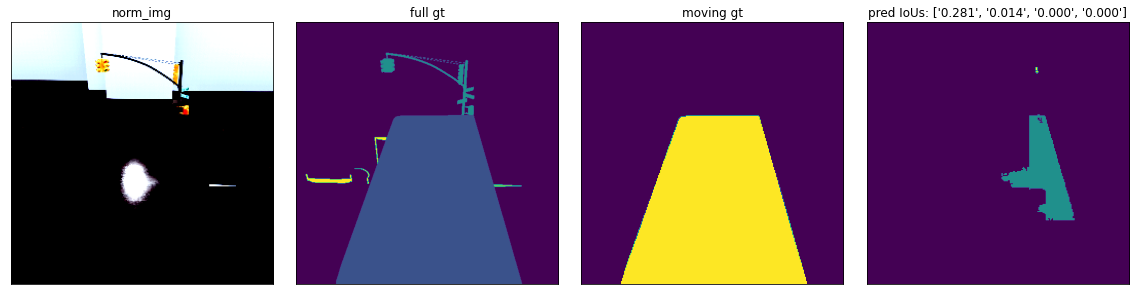

In [14]:
ex = 0
img, pred, gt, ious, ious_per_obj = val_gt_moving_iou(model, tdw_dataset, ex=ex, val_single=False)
_, _, gt_moving = tdw_dataset[ex]
fig, axes = plt.subplots(1,4,figsize=(16,4))

axes[0].imshow(tensor_to_arr(img))
axes[1].imshow(tensor_to_arr(gt))
axes[2].imshow(tensor_to_arr(gt_moving[None,::2,::2]))
axes[3].imshow(tensor_to_arr(pred))

titles = ['norm_img', 'full gt', 'moving gt', "pred IoUs: %s" % ["%.3f" % v for v in list(ious_per_obj[0])]]
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i], fontsize=12)    

# viz(pred[ex][None])
# plt.title("IOUs: %s" % ["%.3f" % v for v in list(ious_per_obj[0])])
# plt.show()
# viz(gt[ex][None])
plt.tight_layout()
plt.show()

In [15]:
out = model(img.cuda())

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


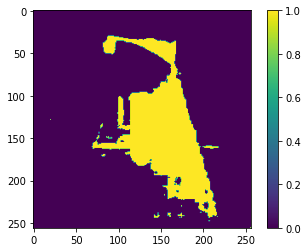

In [16]:
viz(out[4][:,0:1] > 0.15)
plt.colorbar()

In [228]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [229]:
import graph_partition
ins, ins_list = graph_partition.make_ins_seg(out, thresh=0.1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: make_ins_seg() got an unexpected keyword argument 'thresh'